## Installing Packages

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM, GRU
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

## Spliting Data as Train and Test

In [62]:
df_test = pd.read_csv('Google_Stock_Test (2023).csv')
df_train = pd.read_csv('Google_Stock_Train (2010-2022).csv')
df = pd.concat([df_train,df_test])

In [63]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028


## Data Preprocessing

In [64]:
df.info() # to check for data summary 

<class 'pandas.core.frame.DataFrame'>
Index: 3415 entries, 0 to 142
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3415 non-null   object 
 1   Open       3415 non-null   float64
 2   High       3415 non-null   float64
 3   Low        3415 non-null   float64
 4   Close      3415 non-null   float64
 5   Adj Close  3415 non-null   float64
 6   Volume     3415 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 213.4+ KB


In [65]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3415.000000,3415.000000,3415.000000,3415.000000,3415.000000,3.415000e+03
mean,51.602449,52.137050,51.069382,51.615610,51.615610,5.919210e+07
std,37.037725,37.483882,36.606707,37.050992,37.050992,4.883960e+07
min,10.968719,11.068068,10.851602,10.912663,10.912663,9.312000e+06
25%,21.630881,21.804179,21.442317,21.660035,21.660035,2.889500e+07
50%,40.091499,40.338001,39.844002,40.132000,40.132000,4.033400e+07
75%,67.845249,68.434250,67.299999,67.783249,67.783249,7.784608e+07
max,151.250000,151.546494,148.899002,149.838501,149.838501,5.923990e+08


In [66]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [67]:
df.shape

(3415, 7)

In [68]:
df.isnull().sum() #to check for null values

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [69]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [70]:
df    = df.loc[:,["Open"]].values
train = df[:len(df)-50] 
test = df[len(train):] 
# reshape
train = train.reshape(train.shape[0],1)


In [71]:
train.shape

(3365, 1)

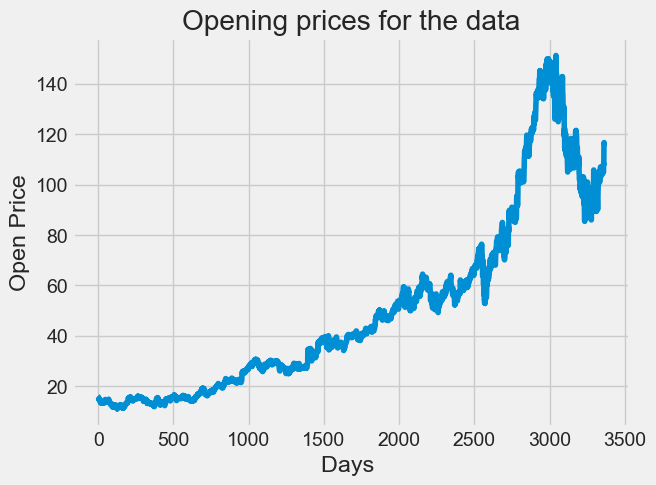

In [72]:
plt.plot(train);
plt.title("Opening prices for the data");
plt.xlabel("Days ")
plt.ylabel("Open Price")
plt.show()

## Normalization / Feature Scaling

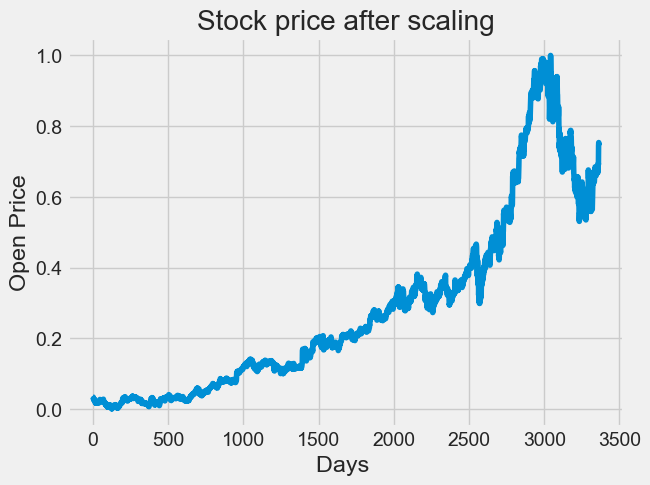

In [73]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1)) # defining of Scaler
train_scaled = scaler.fit_transform(train) # applying to Scaler to train
plt.plot(train_scaled)
plt.xlabel("Days ")
plt.ylabel("Open Price")
plt.title("Stock price after scaling")
plt.show()

## Creating X_train and y_train from scaled Train data

In [74]:
# We add first 50 timesteps to "X_train" and  51 timesteps to "y_train" .
X_train = []
y_train = []
timesteps = 50

for i in range(timesteps, train_scaled.shape[0]):
    X_train.append(train_scaled[i-timesteps:i,0])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)


# Reshaping
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Dimension of array is 3.

## Creating RNN model 

In [75]:
# --- RNN ---

# Importing the Keras libraries and packages

from keras.models import Sequential  
from keras.layers import Dense 
from keras.layers import SimpleRNN
from keras.layers import Dropout # it block to overfitting 

# Initialising the RNN
regressor = Sequential()

# Adding the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) 

# Adding a second RNN layer and some Dropout regularisation.
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation. 
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation.
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
Rnn_history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100


c:\Users\prakh\Desktop\Deep Learning\Assignment 3\Stock-Price-Prediction-using-RNN\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.3890
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1206
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0639
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0415
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0260
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0200
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0168
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0124
Epoch 9/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0098
Epoch 10/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0084
Epoch 11/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0079
Epoch 12/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0054
Epoch 13/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0058
Epoch 14/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0053
Epoch 15/100
104/104 ━━━━━━━━━━━━━━━━━━━━

## Evaluating Model

In [76]:
# Losses
Rnn_history.history["loss"]

[0.2821964621543884,
 0.10172314196825027,
 0.055733952671289444,
 0.03595205768942833,
 0.02514602616429329,
 0.018266556784510612,
 0.015561644919216633,
 0.01220625452697277,
 0.009390689432621002,
 0.007967659272253513,
 0.007123409304767847,
 0.005568420980125666,
 0.005374702624976635,
 0.0051237596198916435,
 0.005120586138218641,
 0.003799454541876912,
 0.0035545469727367163,
 0.003581233788281679,
 0.0030255436431616545,
 0.003326578065752983,
 0.0027148316148668528,
 0.002643547486513853,
 0.002383945509791374,
 0.0024789124727249146,
 0.0022436073049902916,
 0.002117663389071822,
 0.0021649375557899475,
 0.0020124223083257675,
 0.0018521432066336274,
 0.0017273345729336143,
 0.0017415117472410202,
 0.0016266916645690799,
 0.00162172457203269,
 0.001511991024017334,
 0.0014356535393744707,
 0.0013571028830483556,
 0.001350455917418003,
 0.0012612880673259497,
 0.0013822298496961594,
 0.001322257681749761,
 0.001269449945539236,
 0.0012352386256679893,
 0.0011672369437292218,


In [77]:
min_loss = np.min(Rnn_history.history["loss"])
RMSE = math.sqrt(min_loss)
RMSE

0.028763693636794492

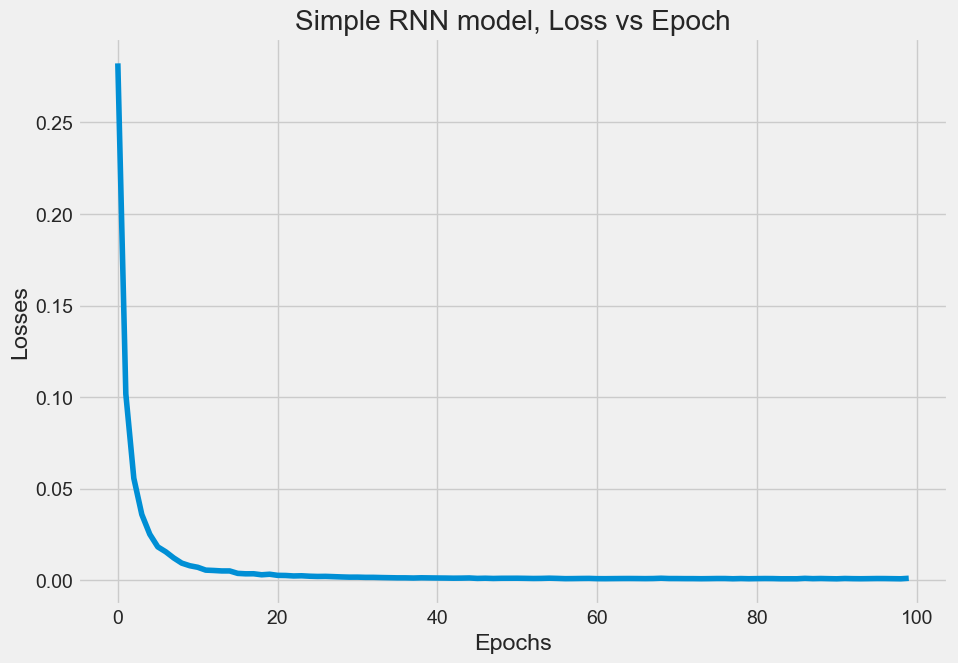

In [78]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(Rnn_history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [79]:
inputs = df[len(df) - len(test) - timesteps:]
inputs = scaler.transform(inputs)  # min max scaler

In [80]:
X_test = []
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i-timesteps:i, 0]) # We get 50 elements by shifting from 0 to 50 and from 1 to 51. 
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Model predictions for train data 

In [81]:
predicted_data = regressor.predict(X_test)
predicted_data = scaler.inverse_transform(predicted_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 899ms/step


In [82]:
rmse = np.sqrt(np.mean(((predicted_data - test) ** 2)))
rmse

np.float64(2.643441328893071)

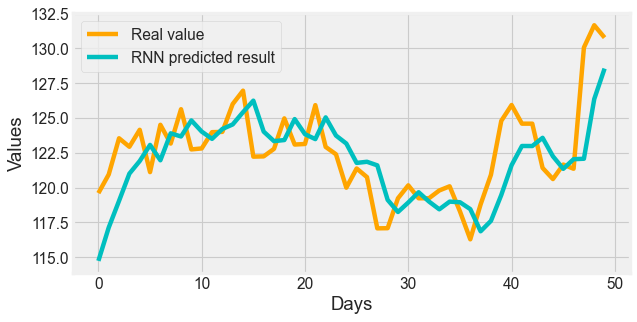

In [83]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="orange",label="Real value")
plt.plot(predicted_data,color="c",label="RNN predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

## Creating LSTM Model

In [84]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [85]:
model = Sequential()
model.add(LSTM(10, input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer='Adam')
history=model.fit(X_train,y_train,epochs=50, batch_size=1)

Epoch 1/50


c:\Users\prakh\Desktop\Deep Learning\Assignment 3\Stock-Price-Prediction-using-RNN\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3315/3315 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 0.0046
Epoch 2/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 3.8423e-04
Epoch 3/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 2.5652e-04
Epoch 4/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 1.9615e-04
Epoch 5/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 1.7081e-04
Epoch 6/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 1.4833e-04
Epoch 7/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 1.3041e-04
Epoch 8/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 1.2084e-04
Epoch 9/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 1.3284e-04
Epoch 10/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 1.0850e-04
Epoch 11/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 1.0458e-04
Epoch 12/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 9.4395e-05
Epoch 13/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 9.7172e-05
Epoch 14/50
3315/3315 ━━━━━━━━━━━━━━

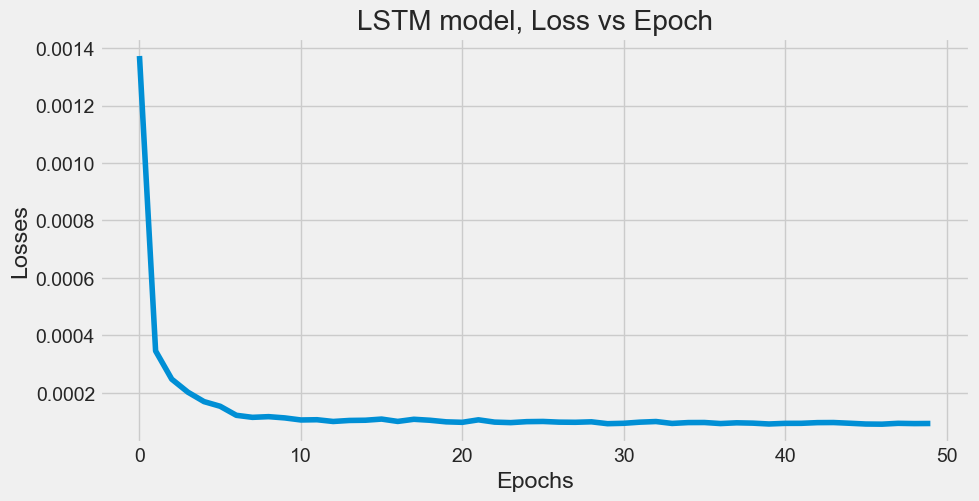

In [86]:
plt.figure(figsize =(10,5))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Loss vs Epoch")
plt.show()

## Model predictions

In [87]:
predicted_data2=model.predict(X_test)
predicted_data2=scaler.inverse_transform(predicted_data2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [88]:
min_loss = np.min(history.history['loss'])
RMSE = math.sqrt(min_loss)
RMSE

0.009517801929846978

In [89]:
rmse = np.sqrt(np.mean(((predicted_data2 - test) ** 2)))
rmse

np.float64(3.0016045573518957)

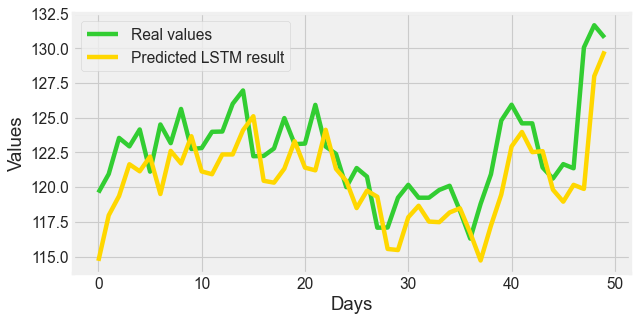

In [90]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="LimeGreen",label="Real values")
plt.plot(predicted_data2,color="Gold",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

## Creating GRU Model

In [91]:
model = Sequential()
model.add(GRU(20, input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer='Adam')
history=model.fit(X_train,y_train,epochs=50, batch_size=1)

Epoch 1/50


c:\Users\prakh\Desktop\Deep Learning\Assignment 3\Stock-Price-Prediction-using-RNN\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3315/3315 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0084
Epoch 2/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.8842e-04
Epoch 3/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.3944e-04
Epoch 4/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 1.2000e-04
Epoch 5/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.1733e-04
Epoch 6/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.2936e-04
Epoch 7/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.2347e-04
Epoch 8/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 9.8984e-05
Epoch 9/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 9.9909e-05
Epoch 10/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 1.0564e-04
Epoch 11/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 9.9671e-05
Epoch 12/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 1.0976e-04
Epoch 13/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.0126e-04
Epoch 14/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 12s 4m

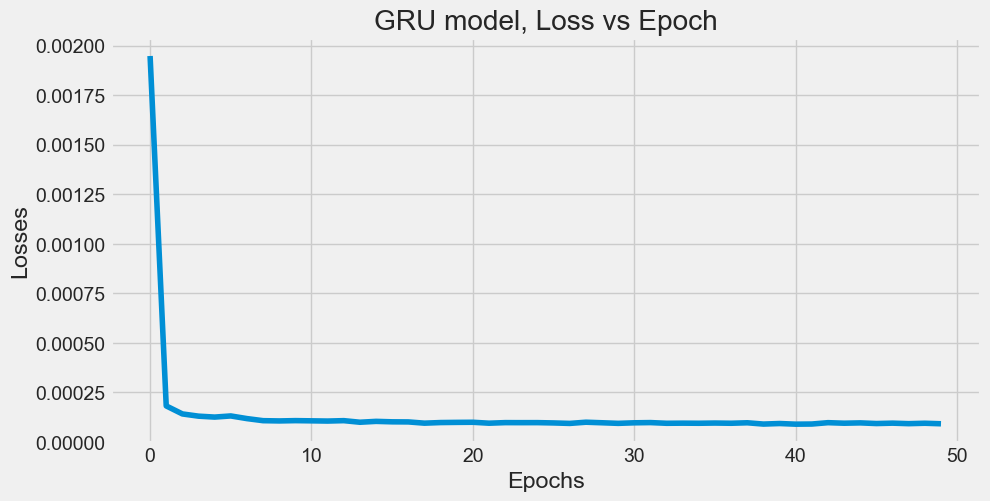

In [92]:
plt.figure(figsize =(10,5))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("GRU model, Loss vs Epoch")
plt.show()

In [93]:
predicted_data3=model.predict(X_test)
predicted_data3=scaler.inverse_transform(predicted_data3)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


In [94]:
min_loss = np.min(history.history['loss'])
RMSE = math.sqrt(min_loss)
RMSE

0.009478589324745218

In [95]:
rmse = np.sqrt(np.mean(((predicted_data2 - test) ** 2)))
rmse

np.float64(3.0016045573518957)

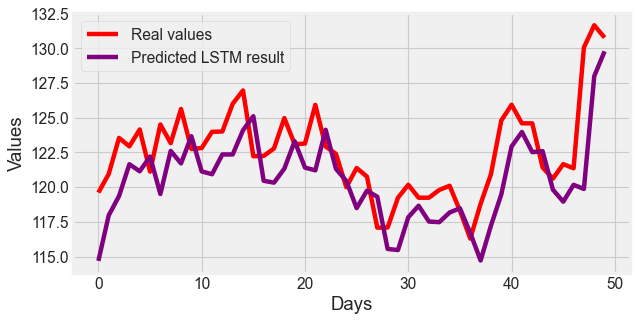

In [96]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="red",label="Real values")
plt.plot(predicted_data2,color="Purple",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

## Comparetive Study of RNN predictions and LSTM predictions

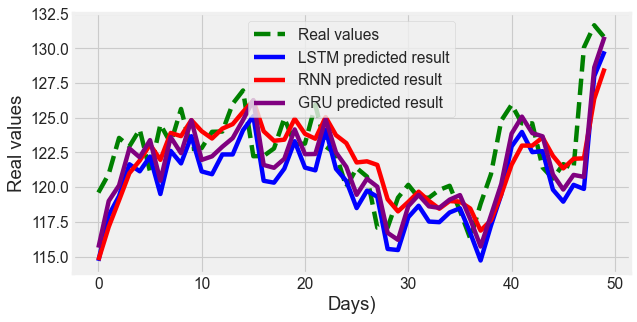

In [97]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="green", linestyle='dashed',label="Real values")
plt.plot(predicted_data2,color="blue", label="LSTM predicted result")
plt.plot(predicted_data,color="red",label="RNN predicted result") #
plt.plot(predicted_data3,color="purple", label="GRU predicted result")
plt.legend()
plt.xlabel("Days)")
plt.ylabel("Real values")
plt.grid(True)
plt.show()